# Почему статистическая значимость не работает в Big Data
## И что использовать вместо p-value

---

### Содержание
1. [Проблема p-value при больших выборках](#problem)
2. [Демонстрация: как большие данные "ломают" p-value](#demo)
3. [Размер эффекта (Effect Size): Cohen's d](#cohens_d)
4. [Практический пример: A/B тест](#ab_test)
5. [Другие метрики размера эффекта](#other_metrics)
6. [Статистическая мощность (Power Analysis)](#power)
7. [Рекомендации для практики](#recommendations)

## Вступление: в чём проблема?

Представьте ситуацию: вы провели A/B тест с миллионом пользователей. Результат показывает **p-value = 0.0001** — ваш вариант статистически значим! Команда празднует победу.

Но подождите... улучшение составило **0.01%**. Стоит ли переписывать весь код ради такого эффекта?

**Это и есть главная проблема:** статистическая значимость отвечает на вопрос *"Есть ли эффект?"*, но не говорит *"Насколько он большой?"*

При больших выборках даже ничтожные различия становятся "статистически значимыми".

In [1]:
# Установка необходимых библиотек (если нужно)
# !pip install numpy scipy statsmodels pingouin matplotlib seaborn

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower

# Настройки визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Фиксируем seed для воспроизводимости
np.random.seed(42)

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


<a id='problem'></a>
## 1. Проблема p-value при больших выборках

### Что такое p-value?

**p-value** — это вероятность получить наблюдаемый результат (или более экстремальный), если бы нулевая гипотеза была верна.

$$p\text{-value} = P(\text{данные} | H_0 \text{ верна})$$

Традиционно:
- p < 0.05 → "статистически значимо"
- p ≥ 0.05 → "не значимо"

### Почему это не работает с Big Data?

Формула t-статистики:

$$t = \frac{\bar{X}_1 - \bar{X}_2}{SE} = \frac{\bar{X}_1 - \bar{X}_2}{s_p \cdot \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

Обратите внимание: **стандартная ошибка (SE) уменьшается с ростом n!**

$$SE \propto \frac{1}{\sqrt{n}}$$

Это означает, что при достаточно большой выборке **любая** разница станет статистически значимой.

<a id='demo'></a>
## 2. Демонстрация: как большие данные "ломают" p-value

Давайте наглядно покажем, как размер выборки влияет на p-value при **одной и той же** разнице между группами.

In [2]:
def demonstrate_sample_size_effect(true_difference=0.05, std=1.0):
    """
    Демонстрирует, как размер выборки влияет на p-value
    при фиксированной истинной разнице между группами.
    
    Parameters:
    -----------
    true_difference : float
        Истинная разница между средними групп (очень маленькая!)
    std : float
        Стандартное отклонение в обеих группах
    """
    
    sample_sizes = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
    p_values = []
    t_statistics = []
    
    print(f"Истинная разница между группами: {true_difference}")
    print(f"Стандартное отклонение: {std}")
    print("\n" + "="*70)
    print(f"{'Размер выборки':>15} | {'t-статистика':>15} | {'p-value':>15} | {'Значимо?':>10}")
    print("="*70)
    
    for n in sample_sizes:
        # Генерируем две группы с маленькой разницей
        group_a = np.random.normal(loc=0, scale=std, size=n)
        group_b = np.random.normal(loc=true_difference, scale=std, size=n)
        
        # Проводим t-тест
        t_stat, p_value = stats.ttest_ind(group_a, group_b)
        
        p_values.append(p_value)
        t_statistics.append(abs(t_stat))
        
        significant = "✓ ДА" if p_value < 0.05 else "✗ Нет"
        print(f"{n:>15,} | {abs(t_stat):>15.4f} | {p_value:>15.6f} | {significant:>10}")
    
    print("="*70)
    
    return sample_sizes, p_values, t_statistics

# Запускаем демонстрацию с ОЧЕНЬ маленькой разницей
sample_sizes, p_values, t_stats = demonstrate_sample_size_effect(true_difference=0.05)

Истинная разница между группами: 0.05
Стандартное отклонение: 1.0

 Размер выборки |    t-статистика |         p-value |   Значимо?
             50 |          1.6211 |        0.108206 |      ✗ Нет
            100 |          0.6412 |        0.522125 |      ✗ Нет
            500 |          2.7687 |        0.005733 |       ✓ ДА
          1,000 |          0.5965 |        0.550923 |      ✗ Нет
          5,000 |          3.7563 |        0.000173 |       ✓ ДА
         10,000 |          2.6865 |        0.007227 |       ✓ ДА
         50,000 |          7.6803 |        0.000000 |       ✓ ДА
        100,000 |         10.2153 |        0.000000 |       ✓ ДА


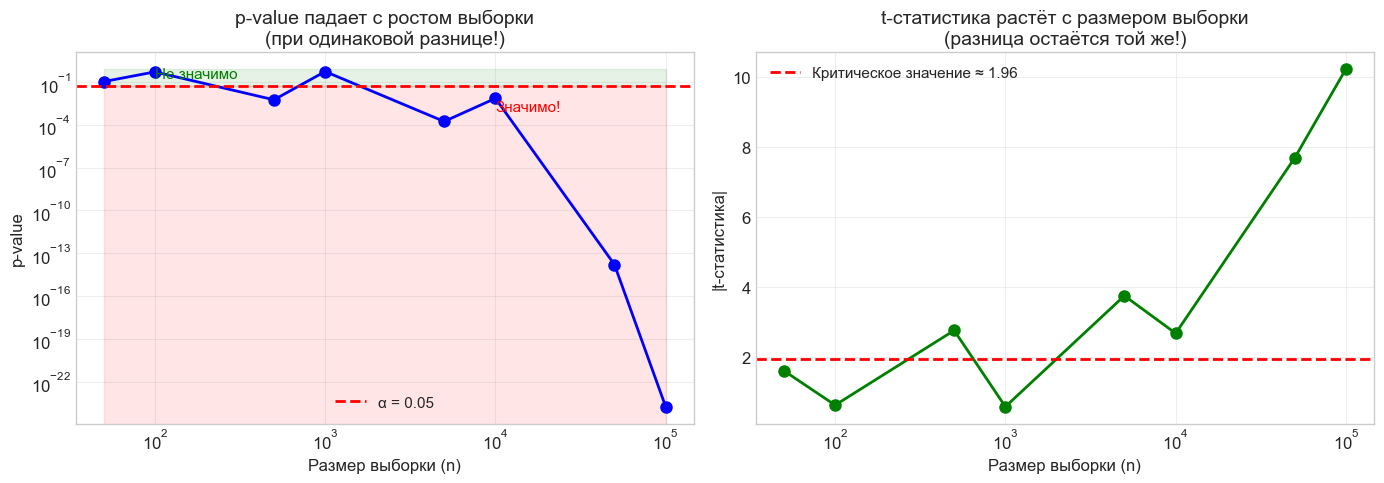


⚠️ ВЫВОД: При достаточно большой выборке ЛЮБАЯ разница становится 'значимой'!


In [3]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: p-value vs размер выборки
ax1 = axes[0]
ax1.plot(sample_sizes, p_values, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='α = 0.05')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Размер выборки (n)', fontsize=12)
ax1.set_ylabel('p-value', fontsize=12)
ax1.set_title('p-value падает с ростом выборки\n(при одинаковой разнице!)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Добавляем аннотации
ax1.fill_between(sample_sizes, 0.05, max(p_values)*1.5, alpha=0.1, color='green')
ax1.fill_between(sample_sizes, 0, 0.05, alpha=0.1, color='red')
ax1.text(100, 0.2, 'Не значимо', fontsize=11, color='green')
ax1.text(10000, 0.001, 'Значимо!', fontsize=11, color='red')

# График 2: t-статистика vs размер выборки
ax2 = axes[1]
ax2.plot(sample_sizes, t_stats, 'go-', linewidth=2, markersize=8)
ax2.axhline(y=1.96, color='r', linestyle='--', linewidth=2, label='Критическое значение ≈ 1.96')
ax2.set_xscale('log')
ax2.set_xlabel('Размер выборки (n)', fontsize=12)
ax2.set_ylabel('|t-статистика|', fontsize=12)
ax2.set_title('t-статистика растёт с размером выборки\n(разница остаётся той же!)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ ВЫВОД: При достаточно большой выборке ЛЮБАЯ разница становится 'значимой'!")

### Ключевой вывод из демонстрации

При **одной и той же** разнице между группами (0.05 единицы):
- При n=50: p-value высокий → "не значимо"
- При n=100,000: p-value очень маленький → "супер-значимо!"

**Но разница-то осталась той же!** Практическая ценность эффекта не изменилась.

Это и есть главная причина, почему нужны альтернативные метрики.

<a id='cohens_d'></a>
## 3. Размер эффекта (Effect Size): Cohen's d

### Что такое размер эффекта?

**Размер эффекта** — это стандартизированная мера того, *насколько велико* различие между группами, независимо от размера выборки.

### Cohen's d — самая популярная метрика

$$d = \frac{\bar{X}_1 - \bar{X}_2}{s_{pooled}}$$

где объединённое стандартное отклонение:

$$s_{pooled} = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}$$

### Интерпретация Cohen's d (по Коэну, 1988)

| Cohen's d | Интерпретация | Пример |
|-----------|--------------|--------|
| 0.2 | Малый эффект | Едва заметная разница |
| 0.5 | Средний эффект | Заметно "невооружённым глазом" |
| 0.8 | Большой эффект | Очевидная разница |

**Главное преимущество:** Cohen's d НЕ зависит от размера выборки!

In [4]:
def cohens_d(group1, group2):
    """
    Вычисляет Cohen's d для двух независимых групп.
    
    Parameters:
    -----------
    group1, group2 : array-like
        Два массива данных для сравнения
        
    Returns:
    --------
    d : float
        Значение Cohen's d
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Объединённое стандартное отклонение
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    
    return d


def interpret_cohens_d(d):
    """
    Интерпретирует значение Cohen's d.
    
    Parameters:
    -----------
    d : float
        Значение Cohen's d
        
    Returns:
    --------
    interpretation : str
        Текстовая интерпретация
    """
    d_abs = abs(d)
    
    if d_abs < 0.2:
        return "Очень малый эффект (пренебрежимо мал)"
    elif d_abs < 0.5:
        return "Малый эффект"
    elif d_abs < 0.8:
        return "Средний эффект"
    else:
        return "Большой эффект"


# Проверим функцию
print("Функции cohens_d() и interpret_cohens_d() готовы к использованию!")

Функции cohens_d() и interpret_cohens_d() готовы к использованию!


In [5]:
# Демонстрация: Cohen's d остаётся стабильным при разных размерах выборки

def demonstrate_cohens_d_stability(true_difference=0.5, std=1.0):
    """
    Показывает, что Cohen's d стабилен при разных размерах выборки.
    """
    sample_sizes = [50, 100, 500, 1000, 5000, 10000, 50000]
    cohens_d_values = []
    p_values = []
    
    # Теоретическое значение Cohen's d
    theoretical_d = true_difference / std
    
    print(f"Истинная разница: {true_difference}, Std: {std}")
    print(f"Теоретический Cohen's d = {theoretical_d:.3f}")
    print("\n" + "="*80)
    print(f"{'Размер выборки':>15} | {'Cohen\'s d':>12} | {'p-value':>15} | {'Интерпретация':>25}")
    print("="*80)
    
    for n in sample_sizes:
        group_a = np.random.normal(loc=0, scale=std, size=n)
        group_b = np.random.normal(loc=true_difference, scale=std, size=n)
        
        d = cohens_d(group_a, group_b)
        _, p = stats.ttest_ind(group_a, group_b)
        
        cohens_d_values.append(d)
        p_values.append(p)
        
        interp = interpret_cohens_d(d)
        print(f"{n:>15,} | {d:>12.4f} | {p:>15.2e} | {interp:>25}")
    
    print("="*80)
    
    return sample_sizes, cohens_d_values, p_values, theoretical_d


# Средний эффект
sizes, d_values, p_vals, true_d = demonstrate_cohens_d_stability(true_difference=0.5, std=1.0)

Истинная разница: 0.5, Std: 1.0
Теоретический Cohen's d = 0.500

 Размер выборки |    Cohen's d |         p-value |             Интерпретация
             50 |      -0.9236 |        1.18e-05 |            Большой эффект
            100 |      -0.5777 |        6.39e-05 |            Средний эффект
            500 |      -0.5912 |        5.67e-20 |            Средний эффект
          1,000 |      -0.5098 |        3.31e-29 |            Средний эффект
          5,000 |      -0.5196 |       4.89e-144 |            Средний эффект
         10,000 |      -0.5102 |       3.65e-276 |            Средний эффект
         50,000 |      -0.4975 |        0.00e+00 |              Малый эффект


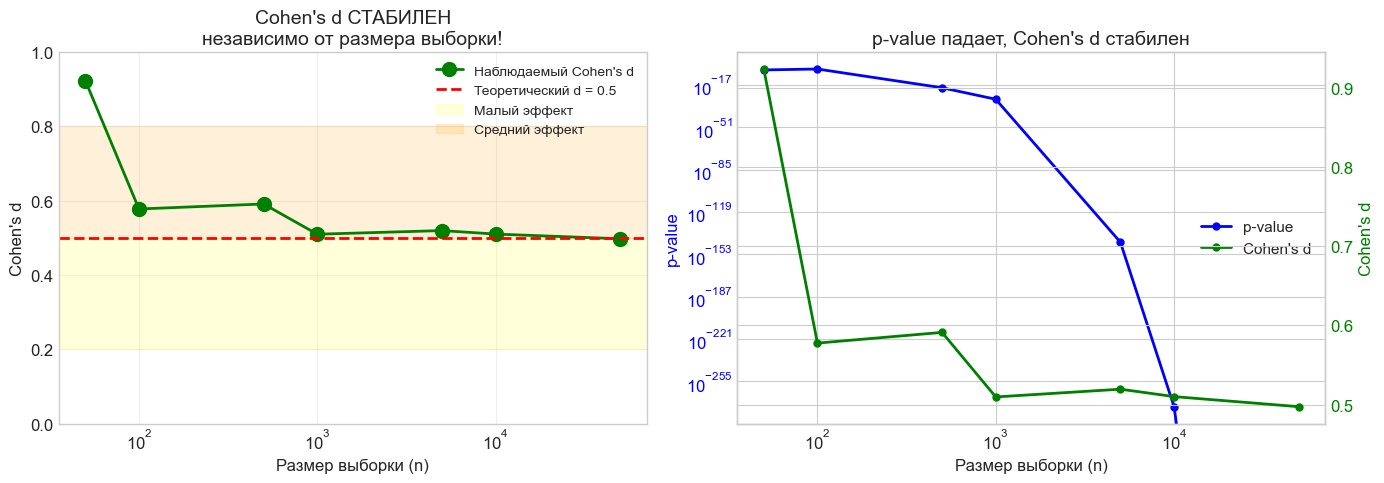


✅ Cohen's d даёт СТАБИЛЬНУЮ оценку размера эффекта!


In [6]:
# Визуализация стабильности Cohen's d
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Cohen's d vs размер выборки
ax1 = axes[0]
ax1.plot(sizes, np.abs(d_values), 'go-', linewidth=2, markersize=10, label="Наблюдаемый Cohen's d")
ax1.axhline(y=true_d, color='r', linestyle='--', linewidth=2, label=f"Теоретический d = {true_d}")
ax1.axhspan(0.2, 0.5, alpha=0.15, color='yellow', label='Малый эффект')
ax1.axhspan(0.5, 0.8, alpha=0.15, color='orange', label='Средний эффект')
ax1.set_xscale('log')
ax1.set_xlabel('Размер выборки (n)', fontsize=12)
ax1.set_ylabel("Cohen's d", fontsize=12)
ax1.set_title("Cohen's d СТАБИЛЕН\nнезависимо от размера выборки!", fontsize=14)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# График 2: Сравнение p-value и Cohen's d
ax2 = axes[1]
ax2_twin = ax2.twinx()

line1, = ax2.plot(sizes, p_vals, 'b.-', linewidth=2, markersize=10, label='p-value')
line2, = ax2_twin.plot(sizes, np.abs(d_values), 'g.-', linewidth=2, markersize=10, label="Cohen's d")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Размер выборки (n)', fontsize=12)
ax2.set_ylabel('p-value', fontsize=12, color='blue')
ax2_twin.set_ylabel("Cohen's d", fontsize=12, color='green')
ax2.set_title('p-value падает, Cohen\'s d стабилен', fontsize=14)
ax2.tick_params(axis='y', labelcolor='blue')
ax2_twin.tick_params(axis='y', labelcolor='green')

lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Cohen's d даёт СТАБИЛЬНУЮ оценку размера эффекта!")

<a id='ab_test'></a>
## 4. Практический пример: A/B тест

Рассмотрим реалистичный сценарий: команда тестирует новую кнопку на сайте. Метрика — конверсия в покупку.

In [7]:
def ab_test_analysis(control_conversions, treatment_conversions, 
                     control_total, treatment_total,
                     average_order_value=100):
    """
    Полный анализ A/B теста с p-value И размером эффекта.
    
    Parameters:
    -----------
    control_conversions : int
        Количество конверсий в контрольной группе
    treatment_conversions : int
        Количество конверсий в тестовой группе
    control_total : int
        Общее количество пользователей в контроле
    treatment_total : int
        Общее количество пользователей в тесте
    average_order_value : float
        Средний чек (для расчёта бизнес-эффекта)
    """
    
    # Конверсии
    p_control = control_conversions / control_total
    p_treatment = treatment_conversions / treatment_total
    
    # Абсолютная и относительная разница
    absolute_diff = p_treatment - p_control
    relative_lift = (p_treatment - p_control) / p_control * 100
    
    # Z-тест для пропорций
    p_pooled = (control_conversions + treatment_conversions) / (control_total + treatment_total)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/control_total + 1/treatment_total))
    z_stat = (p_treatment - p_control) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # двусторонний тест
    
    # Cohen's h (аналог Cohen's d для пропорций)
    # h = 2 * (arcsin(sqrt(p1)) - arcsin(sqrt(p2)))
    cohens_h = 2 * (np.arcsin(np.sqrt(p_treatment)) - np.arcsin(np.sqrt(p_control)))
    
    # Бизнес-эффект (потенциальная выручка в месяц)
    monthly_visitors = 1_000_000  # предположим
    additional_revenue = monthly_visitors * absolute_diff * average_order_value
    
    # Вывод результатов
    print("="*60)
    print("           РЕЗУЛЬТАТЫ A/B ТЕСТА")
    print("="*60)
    
    print(f"\n📊 БАЗОВЫЕ МЕТРИКИ:")
    print(f"   Контроль:   {p_control*100:.3f}% ({control_conversions:,} / {control_total:,})")
    print(f"   Тест:       {p_treatment*100:.3f}% ({treatment_conversions:,} / {treatment_total:,})")
    print(f"   Разница:    {absolute_diff*100:+.4f}% (абсолютная)")
    print(f"   Lift:       {relative_lift:+.2f}% (относительный)")
    
    print(f"\n📈 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:")
    print(f"   Z-статистика: {z_stat:.4f}")
    print(f"   p-value:      {p_value:.6f}")
    stat_sig = "✅ ДА" if p_value < 0.05 else "❌ НЕТ"
    print(f"   Значимо (α=0.05)? {stat_sig}")
    
    print(f"\n📐 РАЗМЕР ЭФФЕКТА:")
    print(f"   Cohen's h: {cohens_h:.4f}")
    
    # Интерпретация Cohen's h
    h_abs = abs(cohens_h)
    if h_abs < 0.2:
        h_interp = "Очень малый (пренебрежимо мал)"
    elif h_abs < 0.5:
        h_interp = "Малый"
    elif h_abs < 0.8:
        h_interp = "Средний"
    else:
        h_interp = "Большой"
    print(f"   Интерпретация: {h_interp}")
    
    print(f"\n💰 БИЗНЕС-ЭФФЕКТ (оценка):")
    print(f"   При {monthly_visitors:,} посетителей/мес:")
    print(f"   Доп. выручка: ${additional_revenue:,.0f}/месяц")
    
    print("\n" + "="*60)
    
    # Рекомендация
    print("\n🎯 РЕКОМЕНДАЦИЯ:")
    if p_value < 0.05 and h_abs >= 0.2:
        print("   ✅ Внедрять! Эффект статистически значим И практически значим.")
    elif p_value < 0.05 and h_abs < 0.2:
        print("   ⚠️ Осторожно! Статистически значимо, но эффект ОЧЕНЬ мал.")
        print("      Возможно, не стоит затрат на внедрение.")
    elif p_value >= 0.05 and h_abs >= 0.2:
        print("   🔄 Продолжить тест! Есть потенциальный эффект, но нужно больше данных.")
    else:
        print("   ❌ Не внедрять. Нет ни статистической, ни практической значимости.")
    
    return {
        'p_value': p_value,
        'cohens_h': cohens_h,
        'absolute_diff': absolute_diff,
        'relative_lift': relative_lift
    }

In [25]:
# Сценарий 1: Статистически значимо, но практически бесполезно
print("\n" + "#"*60)
print("# СЦЕНАРИЙ 1: Огромная выборка, крошечный эффект")
print("#"*60)

result1 = ab_test_analysis(
    control_conversions=50_000,
    treatment_conversions=90_150,   # +150 конверсий
    control_total=1_000_000,
    treatment_total=1_000_000
)


############################################################
# СЦЕНАРИЙ 1: Огромная выборка, крошечный эффект
############################################################
           РЕЗУЛЬТАТЫ A/B ТЕСТА

📊 БАЗОВЫЕ МЕТРИКИ:
   Контроль:   5.000% (50,000 / 1,000,000)
   Тест:       9.015% (90,150 / 1,000,000)
   Разница:    +4.0150% (абсолютная)
   Lift:       +80.30% (относительный)

📈 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   Z-статистика: 111.2154
   p-value:      0.000000
   Значимо (α=0.05)? ✅ ДА

📐 РАЗМЕР ЭФФЕКТА:
   Cohen's h: 0.1589
   Интерпретация: Очень малый (пренебрежимо мал)

💰 БИЗНЕС-ЭФФЕКТ (оценка):
   При 1,000,000 посетителей/мес:
   Доп. выручка: $4,015,000/месяц


🎯 РЕКОМЕНДАЦИЯ:
   ⚠️ Осторожно! Статистически значимо, но эффект ОЧЕНЬ мал.
      Возможно, не стоит затрат на внедрение.


In [23]:
# Сценарий 2: Настоящее улучшение
print("\n" + "#"*60)
print("# СЦЕНАРИЙ 2: Реальное улучшение")
print("#"*60)

result2 = ab_test_analysis(
    control_conversions=5_000,
    treatment_conversions=5_500,    # +500 конверсий (+10%)
    control_total=100_000,
    treatment_total=100_000
)


############################################################
# СЦЕНАРИЙ 2: Реальное улучшение
############################################################
           РЕЗУЛЬТАТЫ A/B ТЕСТА

📊 БАЗОВЫЕ МЕТРИКИ:
   Контроль:   5.000% (5,000 / 100,000)
   Тест:       5.500% (5,500 / 100,000)
   Разница:    +0.5000% (абсолютная)
   Lift:       +10.00% (относительный)

📈 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   Z-статистика: 5.0129
   p-value:      0.000001
   Значимо (α=0.05)? ✅ ДА

📐 РАЗМЕР ЭФФЕКТА:
   Cohen's h: 0.0224
   Интерпретация: Очень малый (пренебрежимо мал)

💰 БИЗНЕС-ЭФФЕКТ (оценка):
   При 1,000,000 посетителей/мес:
   Доп. выручка: $500,000/месяц


🎯 РЕКОМЕНДАЦИЯ:
   ⚠️ Осторожно! Статистически значимо, но эффект ОЧЕНЬ мал.
      Возможно, не стоит затрат на внедрение.


In [10]:
# Сценарий 3: Мало данных, но большой эффект
print("\n" + "#"*60)
print("# СЦЕНАРИЙ 3: Малая выборка, большой потенциальный эффект")
print("#"*60)

result3 = ab_test_analysis(
    control_conversions=50,
    treatment_conversions=65,    # +30%
    control_total=1000,
    treatment_total=1000
)


############################################################
# СЦЕНАРИЙ 3: Малая выборка, большой потенциальный эффект
############################################################
           РЕЗУЛЬТАТЫ A/B ТЕСТА

📊 БАЗОВЫЕ МЕТРИКИ:
   Контроль:   5.000% (50 / 1,000)
   Тест:       6.500% (65 / 1,000)
   Разница:    +1.5000% (абсолютная)
   Lift:       +30.00% (относительный)

📈 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   Z-статистика: 1.4408
   p-value:      0.149643
   Значимо (α=0.05)? ❌ НЕТ

📐 РАЗМЕР ЭФФЕКТА:
   Cohen's h: 0.0646
   Интерпретация: Очень малый (пренебрежимо мал)

💰 БИЗНЕС-ЭФФЕКТ (оценка):
   При 1,000,000 посетителей/мес:
   Доп. выручка: $1,500,000/месяц


🎯 РЕКОМЕНДАЦИЯ:
   ❌ Не внедрять. Нет ни статистической, ни практической значимости.


### Выводы из сценариев:

| Сценарий | p-value | Cohen's h | Рекомендация |
|----------|---------|-----------|-------------|
| 1. Огромная выборка, микро-эффект | <0.05 ✅ | <0.2 ❌ | НЕ внедрять |
| 2. Нормальная выборка, хороший эффект | <0.05 ✅ | ≥0.2 ✅ | Внедрять! |
| 3. Малая выборка, потенциальный эффект | >0.05 ❌ | ≥0.2 ✅ | Продолжить тест |

<a id='other_metrics'></a>
## 5. Другие метрики размера эффекта

Cohen's d — не единственная метрика. Выбор зависит от типа данных и анализа.

In [11]:
def glass_delta(treatment, control):
    """
    Glass's delta — использует только стандартное отклонение контрольной группы.
    Полезно, когда дисперсии групп различаются.
    """
    return (np.mean(treatment) - np.mean(control)) / np.std(control, ddof=1)


def hedges_g(group1, group2):
    """
    Hedges' g — корректировка Cohen's d для малых выборок.
    Рекомендуется при n < 20 в каждой группе.
    """
    n1, n2 = len(group1), len(group2)
    d = cohens_d(group1, group2)
    
    # Корректировка для малых выборок
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    
    return d * correction


def eta_squared(f_statistic, df_between, df_within):
    """
    Eta squared (η²) — для ANOVA.
    Показывает долю дисперсии, объяснённую фактором.
    """
    ss_between = f_statistic * df_between * (1 / df_within)  # приближение
    ss_total = ss_between + 1  # нормализация
    
    return ss_between / ss_total


def cramers_v(contingency_table):
    """
    Cramer's V — для категориальных данных (chi-square).
    
    Parameters:
    -----------
    contingency_table : array-like
        Таблица сопряжённости
    """
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    n = np.sum(contingency_table)
    min_dim = min(contingency_table.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))

In [12]:
# Сравнение метрик на примере
np.random.seed(42)

# Группы с разными дисперсиями
control = np.random.normal(loc=100, scale=15, size=30)
treatment = np.random.normal(loc=110, scale=25, size=30)  # большая дисперсия

print("Сравнение метрик размера эффекта")
print("="*50)
print(f"Контроль:  μ = {np.mean(control):.2f}, σ = {np.std(control, ddof=1):.2f}")
print(f"Тест:      μ = {np.mean(treatment):.2f}, σ = {np.std(treatment, ddof=1):.2f}")
print("="*50)

d = cohens_d(treatment, control)
delta = glass_delta(treatment, control)
g = hedges_g(treatment, control)

print(f"\nCohen's d:     {d:.4f}  (использует pooled std)")
print(f"Glass's Δ:     {delta:.4f}  (использует только std контроля)")
print(f"Hedges' g:     {g:.4f}  (коррекция для малых n)")

print("\n" + "="*50)
print("Когда что использовать:")
print("-"*50)
print("Cohen's d:   Стандартный выбор, равные дисперсии")
print("Glass's Δ:   Дисперсии различаются, важен контроль")
print("Hedges' g:   Малые выборки (n < 20)")

Сравнение метрик размера эффекта
Контроль:  μ = 97.18, σ = 13.50
Тест:      μ = 106.97, σ = 23.28

Cohen's d:     0.5147  (использует pooled std)
Glass's Δ:     0.7254  (использует только std контроля)
Hedges' g:     0.5080  (коррекция для малых n)

Когда что использовать:
--------------------------------------------------
Cohen's d:   Стандартный выбор, равные дисперсии
Glass's Δ:   Дисперсии различаются, важен контроль
Hedges' g:   Малые выборки (n < 20)


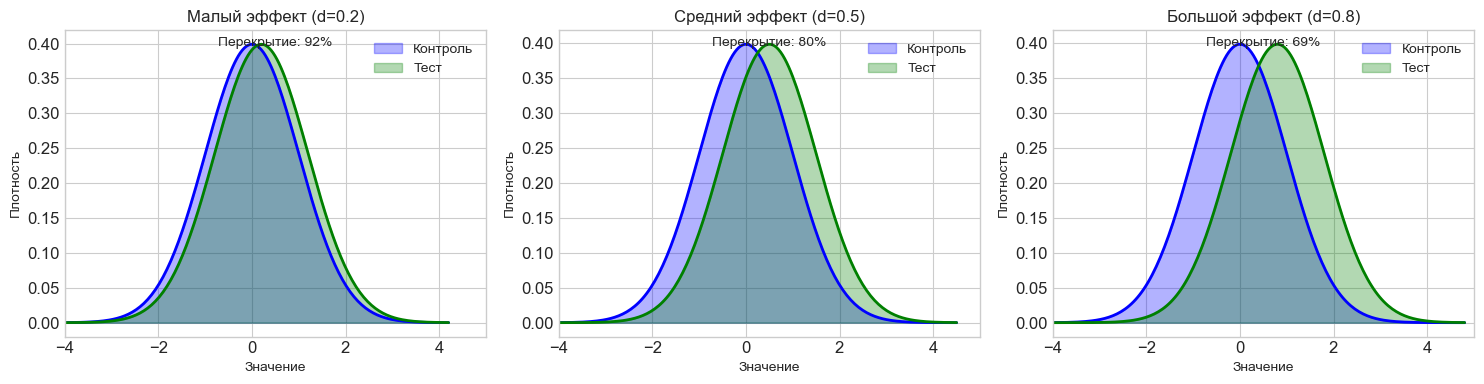


📊 Чем больше Cohen's d, тем меньше перекрытие распределений!


In [13]:
# Визуализация распределений с Cohen's d
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

effect_sizes = [0.2, 0.5, 0.8]
titles = ['Малый эффект (d=0.2)', 'Средний эффект (d=0.5)', 'Большой эффект (d=0.8)']

for ax, d, title in zip(axes, effect_sizes, titles):
    x = np.linspace(-4, 4 + d, 200)
    
    # Контрольная группа (синяя)
    y_control = stats.norm.pdf(x, loc=0, scale=1)
    ax.fill_between(x, y_control, alpha=0.3, color='blue', label='Контроль')
    ax.plot(x, y_control, 'b-', linewidth=2)
    
    # Тестовая группа (зелёная, сдвинутая)
    y_treatment = stats.norm.pdf(x, loc=d, scale=1)
    ax.fill_between(x, y_treatment, alpha=0.3, color='green', label='Тест')
    ax.plot(x, y_treatment, 'g-', linewidth=2)
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Значение', fontsize=10)
    ax.set_ylabel('Плотность', fontsize=10)
    ax.legend(fontsize=10)
    ax.set_xlim(-4, 5)
    
    # Аннотация перекрытия
    overlap = 2 * stats.norm.cdf(-d/2) * 100
    ax.annotate(f'Перекрытие: {overlap:.0f}%', 
                xy=(0.5, 0.95), xycoords='axes fraction',
                fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("\n📊 Чем больше Cohen's d, тем меньше перекрытие распределений!")

### Справочная таблица метрик

| Тип анализа | Метрика | Малый | Средний | Большой |
|------------|---------|-------|---------|--------|
| t-тест | Cohen's d | 0.2 | 0.5 | 0.8 |
| Пропорции | Cohen's h | 0.2 | 0.5 | 0.8 |
| Корреляция | Pearson's r | 0.1 | 0.3 | 0.5 |
| Chi-square | Cramer's V | 0.1 | 0.3 | 0.5 |
| ANOVA | η² (eta squared) | 0.01 | 0.06 | 0.14 |
| Регрессия | R² | 0.02 | 0.13 | 0.26 |

<a id='power'></a>
## 6. Статистическая мощность (Power Analysis)

**Мощность теста** — вероятность обнаружить эффект, если он реально существует.

$$\text{Power} = 1 - \beta$$

где β — вероятность ошибки II рода (пропустить реальный эффект).

### Связь между мощностью, размером эффекта и выборкой

При фиксированных α и мощности:
- **Больший размер эффекта** → нужна **меньшая** выборка
- **Меньший размер эффекта** → нужна **бóльшая** выборка

In [14]:
from statsmodels.stats.power import TTestIndPower, TTestPower

def calculate_required_sample_size(effect_size, power=0.8, alpha=0.05):
    """
    Расчёт необходимого размера выборки для заданного размера эффекта.
    
    Parameters:
    -----------
    effect_size : float
        Ожидаемый Cohen's d
    power : float
        Желаемая мощность теста (обычно 0.8)
    alpha : float
        Уровень значимости (обычно 0.05)
        
    Returns:
    --------
    n : float
        Размер выборки для КАЖДОЙ группы
    """
    power_analysis = TTestIndPower()
    n = power_analysis.solve_power(
        effect_size=effect_size, 
        power=power, 
        alpha=alpha,
        ratio=1.0  # равные группы
    )
    return np.ceil(n)


# Демонстрация
print("Необходимый размер выборки (на группу) для Power=80%:")
print("="*55)

for d in [0.2, 0.3, 0.5, 0.8, 1.0]:
    n = calculate_required_sample_size(d)
    total = 2 * n
    interp = interpret_cohens_d(d)
    print(f"Cohen's d = {d:.1f} ({interp:>20}): n = {n:>6.0f} (всего {total:,.0f})")

Необходимый размер выборки (на группу) для Power=80%:
Cohen's d = 0.2 (        Малый эффект): n =    394 (всего 788)
Cohen's d = 0.3 (        Малый эффект): n =    176 (всего 352)
Cohen's d = 0.5 (      Средний эффект): n =     64 (всего 128)
Cohen's d = 0.8 (      Большой эффект): n =     26 (всего 52)
Cohen's d = 1.0 (      Большой эффект): n =     17 (всего 34)


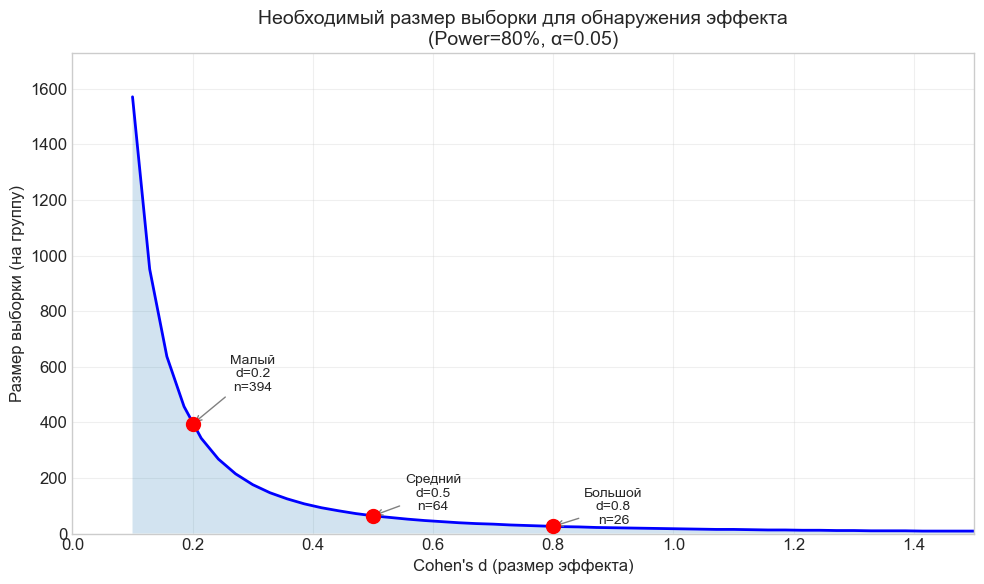


💡 Вывод: для обнаружения малых эффектов нужны ОГРОМНЫЕ выборки!


In [15]:
# Визуализация взаимосвязи: размер эффекта vs необходимая выборка

effect_sizes = np.linspace(0.1, 1.5, 50)
sample_sizes = [calculate_required_sample_size(d) for d in effect_sizes]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(effect_sizes, sample_sizes, 'b-', linewidth=2)
ax.fill_between(effect_sizes, sample_sizes, alpha=0.2)

# Добавляем аннотации для ключевых точек
key_points = [(0.2, 'Малый'), (0.5, 'Средний'), (0.8, 'Большой')]
for d, label in key_points:
    n = calculate_required_sample_size(d)
    ax.scatter([d], [n], s=100, zorder=5, color='red')
    ax.annotate(f'{label}\nd={d}\nn={n:.0f}', 
                xy=(d, n), xytext=(d+0.1, n*1.3),
                fontsize=10, ha='center',
                arrowprops=dict(arrowstyle='->', color='gray'))

ax.set_xlabel("Cohen's d (размер эффекта)", fontsize=12)
ax.set_ylabel('Размер выборки (на группу)', fontsize=12)
ax.set_title('Необходимый размер выборки для обнаружения эффекта\n(Power=80%, α=0.05)', fontsize=14)
ax.set_xlim(0, 1.5)
ax.set_ylim(0, max(sample_sizes) * 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Вывод: для обнаружения малых эффектов нужны ОГРОМНЫЕ выборки!")

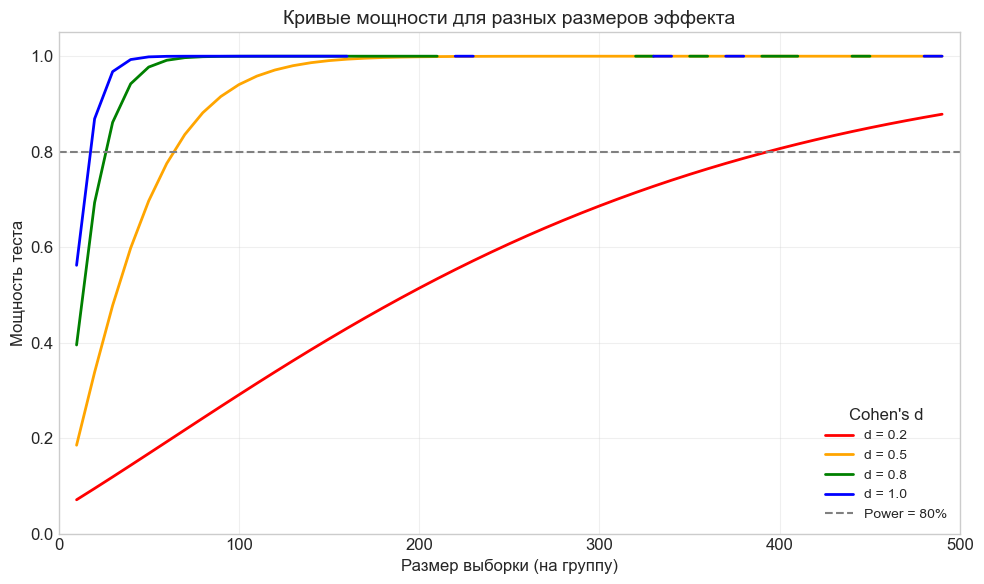

In [16]:
# Кривые мощности для разных размеров эффекта

power_analysis = TTestIndPower()
sample_sizes_range = np.arange(10, 500, 10)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red', 'orange', 'green', 'blue']
effect_sizes_demo = [0.2, 0.5, 0.8, 1.0]

for d, color in zip(effect_sizes_demo, colors):
    powers = [power_analysis.power(effect_size=d, nobs1=n, alpha=0.05, ratio=1.0) 
              for n in sample_sizes_range]
    ax.plot(sample_sizes_range, powers, '-', linewidth=2, color=color, label=f"d = {d}")

ax.axhline(y=0.8, color='gray', linestyle='--', linewidth=1.5, label='Power = 80%')
ax.set_xlabel('Размер выборки (на группу)', fontsize=12)
ax.set_ylabel('Мощность теста', fontsize=12)
ax.set_title('Кривые мощности для разных размеров эффекта', fontsize=14)
ax.legend(title="Cohen's d", fontsize=10)
ax.set_xlim(0, 500)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<a id='recommendations'></a>
## 7. Рекомендации для практики

### Чек-лист для анализа данных

1. **ДО эксперимента:**
   - Определите минимальный практически значимый эффект (MDES)
   - Рассчитайте необходимый размер выборки
   - Задокументируйте план анализа

2. **ПОСЛЕ эксперимента:**
   - Сообщите И p-value, И размер эффекта
   - Добавьте доверительные интервалы
   - Оцените практическую значимость (бизнес-эффект)

3. **При интерпретации:**
   - p < 0.05 НЕ означает "важный эффект"
   - p > 0.05 НЕ означает "эффекта нет"
   - Размер эффекта показывает, насколько велика разница

In [17]:
def full_analysis_report(group1, group2, group1_name='Контроль', group2_name='Тест', alpha=0.05):
    """
    Полный отчёт об анализе двух групп.
    Включает статистическую значимость, размер эффекта и доверительные интервалы.
    """
    # Базовая статистика
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # t-тест
    t_stat, p_value = stats.ttest_ind(group1, group2)
    
    # Размер эффекта
    d = cohens_d(group1, group2)
    g = hedges_g(group1, group2)
    
    # 95% CI для разницы средних
    diff = mean1 - mean2
    se_diff = np.sqrt(std1**2/n1 + std2**2/n2)
    ci_lower = diff - 1.96 * se_diff
    ci_upper = diff + 1.96 * se_diff
    
    # Мощность теста (апостериорная)
    power_analysis = TTestIndPower()
    observed_power = power_analysis.power(effect_size=abs(d), nobs1=n1, alpha=alpha, ratio=n2/n1)
    
    print("\n" + "="*70)
    print("              ПОЛНЫЙ СТАТИСТИЧЕСКИЙ ОТЧЁТ")
    print("="*70)
    
    print(f"\n📋 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
    print(f"   {group1_name:>12}: n = {n1:>6}, μ = {mean1:>8.3f}, σ = {std1:>8.3f}")
    print(f"   {group2_name:>12}: n = {n2:>6}, μ = {mean2:>8.3f}, σ = {std2:>8.3f}")
    
    print(f"\n📊 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:")
    print(f"   t-статистика:  {t_stat:.4f}")
    print(f"   p-value:       {p_value:.6f}")
    sig_symbol = "✅" if p_value < alpha else "❌"
    print(f"   Значимо при α={alpha}? {sig_symbol} {'Да' if p_value < alpha else 'Нет'}")
    
    print(f"\n📐 РАЗМЕР ЭФФЕКТА:")
    print(f"   Cohen's d:     {d:.4f}")
    print(f"   Hedges' g:     {g:.4f}")
    print(f"   Интерпретация: {interpret_cohens_d(d)}")
    
    print(f"\n📏 ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ:")
    print(f"   Разница средних: {diff:.4f}")
    print(f"   95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    print(f"\n⚡ МОЩНОСТЬ ТЕСТА:")
    print(f"   Наблюдаемая мощность: {observed_power:.1%}")
    if observed_power < 0.8:
        print(f"   ⚠️ Предупреждение: мощность ниже рекомендуемых 80%!")
    
    print("\n" + "="*70)
    
    return {
        'p_value': p_value,
        'cohens_d': d,
        'hedges_g': g,
        'ci': (ci_lower, ci_upper),
        'power': observed_power
    }

In [18]:
# Демонстрация полного отчёта
np.random.seed(123)

# Генерируем данные со средним эффектом
control_group = np.random.normal(loc=100, scale=15, size=50)
treatment_group = np.random.normal(loc=108, scale=15, size=50)

results = full_analysis_report(control_group, treatment_group)


              ПОЛНЫЙ СТАТИСТИЧЕСКИЙ ОТЧЁТ

📋 ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
       Контроль: n =     50, μ =  100.199, σ =   18.026
           Тест: n =     50, μ =  108.614, σ =   16.109

📊 СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   t-статистика:  -2.4614
   p-value:       0.015587
   Значимо при α=0.05? ✅ Да

📐 РАЗМЕР ЭФФЕКТА:
   Cohen's d:     -0.4923
   Hedges' g:     -0.4885
   Интерпретация: Малый эффект

📏 ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ:
   Разница средних: -8.4151
   95% CI: [-15.1160, -1.7142]

⚡ МОЩНОСТЬ ТЕСТА:
   Наблюдаемая мощность: 68.3%
   ⚠️ Предупреждение: мощность ниже рекомендуемых 80%!



## Итоговая шпаргалка

### Проблема
- p-value зависит от размера выборки
- При Big Data любая разница становится "значимой"
- p-value не говорит о величине эффекта

### Решение
- Всегда сообщайте размер эффекта (Cohen's d, η², r и др.)
- Заранее определяйте минимально значимый эффект
- Используйте power analysis для планирования

### Интерпретация Cohen's d
- d = 0.2 → Малый (едва заметный)
- d = 0.5 → Средний (видимый "невооружённым глазом")
- d = 0.8 → Большой (очевидный)

### Золотое правило
> "Статистическая значимость без практической значимости бесполезна."
>
> — Каждый data scientist, наступивший на эти грабли

In [19]:
# Бонус: удобные функции для копирования в ваши проекты

# Можете скопировать эти функции в свой код:

print("""
📦 ГОТОВЫЕ ФУНКЦИИ ДЛЯ ИСПОЛЬЗОВАНИЯ:

1. cohens_d(group1, group2)           - Cohen's d для двух групп
2. hedges_g(group1, group2)           - Hedges' g (для малых выборок)
3. glass_delta(treatment, control)    - Glass's Δ (разные дисперсии)
4. interpret_cohens_d(d)              - Текстовая интерпретация
5. calculate_required_sample_size(d)  - Расчёт выборки для power=80%
6. ab_test_analysis(...)              - Полный анализ A/B теста
7. full_analysis_report(...)          - Подробный статистический отчёт
""")

print("\n✅ Тетрадь завершена! Теперь вы вооружены против ловушки p-value.")


📦 ГОТОВЫЕ ФУНКЦИИ ДЛЯ ИСПОЛЬЗОВАНИЯ:

1. cohens_d(group1, group2)           - Cohen's d для двух групп
2. hedges_g(group1, group2)           - Hedges' g (для малых выборок)
3. glass_delta(treatment, control)    - Glass's Δ (разные дисперсии)
4. interpret_cohens_d(d)              - Текстовая интерпретация
5. calculate_required_sample_size(d)  - Расчёт выборки для power=80%
6. ab_test_analysis(...)              - Полный анализ A/B теста
7. full_analysis_report(...)          - Подробный статистический отчёт


✅ Тетрадь завершена! Теперь вы вооружены против ловушки p-value.


---

## Дополнительные ресурсы

1. Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences*
2. Wasserstein, R. L., & Lazar, N. A. (2016). The ASA Statement on p-Values
3. Sullivan, G. M., & Feinn, R. (2012). Using Effect Size—or Why the P Value Is Not Enough

### Полезные Python-библиотеки:
- `pingouin` — упрощённый расчёт effect size
- `statsmodels` — power analysis
- `scipy.stats` — статистические тесты